In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append("../")
device="cuda:0"
from tqdm import tqdm_notebook as tqdm

In [2]:
from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

In [3]:
saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/chair/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook12/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)

In [4]:
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)

In [5]:
os.makedirs(args.model_path, exist_ok=True)

In [16]:
os.makedirs(args.model_path, exist_ok=True)
gaussians = GaussianModel(3)#.to(device="cuda")
scene = Scene(dataset, gaussians, shuffle=True)

#gaussians.restore(torch.load("/home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2/chkpnt1.pth")[0], opt)
gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [17]:
gaussians.restore(torch.load("/home/dimakot55/output_data/gs_fitted/gs_fitted/GT_hotdog_spheres/chkpnt30000.pth")[0], opt)

In [18]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

render_pkg = render(viewpoint_cam, gaussians, pipe, background)


In [19]:
gaussians.restore(torch.load("/home/dimakot55/output_data/gs_fitted/gs_fitted/GT_hotdog_spheres/chkpnt30000.pth")[0], opt)
with torch.no_grad():
    gaussians._opacity = gaussians._opacity + torch.ones_like(gaussians._opacity) * 10.
    gaussians._scaling = gaussians._scaling + torch.ones_like(gaussians._scaling) * 2
# for attr in ['_xyz', '_features_dc', '_features_rest', '_scaling', '_rotation', '_opacity', 'max_radii2D', 'xyz_gradient_accum', 'denom']:
#     setattr(gaussians_test, attr, getattr(gaussians, attr))#.detach().clone())

NameError: name 'gaussians_test' is not defined

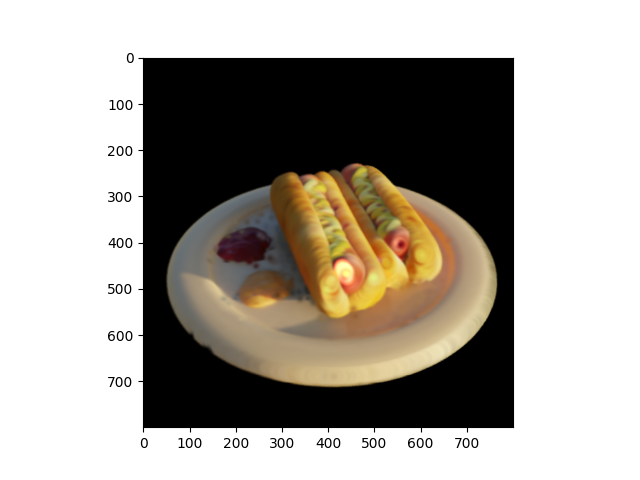

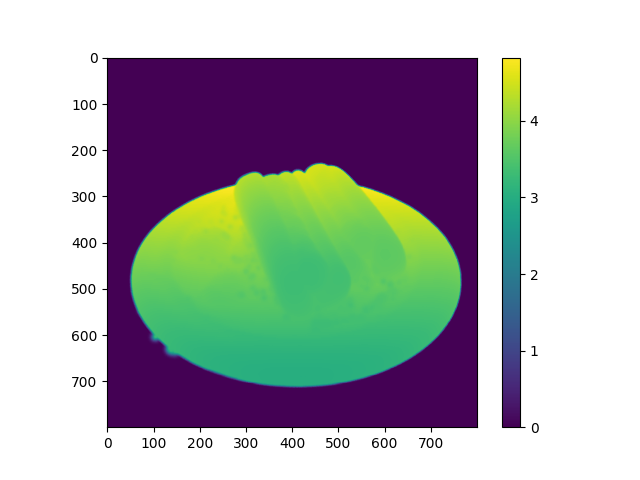

In [33]:
# if not viewpoint_stack:
#         viewpoint_stack = scene_test.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg_test = render(viewpoint_cam, gaussians, pipe, background)
image, depth= render_pkg_test["render"], render_pkg_test["depth"]
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)

# Clip values to be in the range [0, 1]
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [35]:

depth_target = depth.clone().detach()

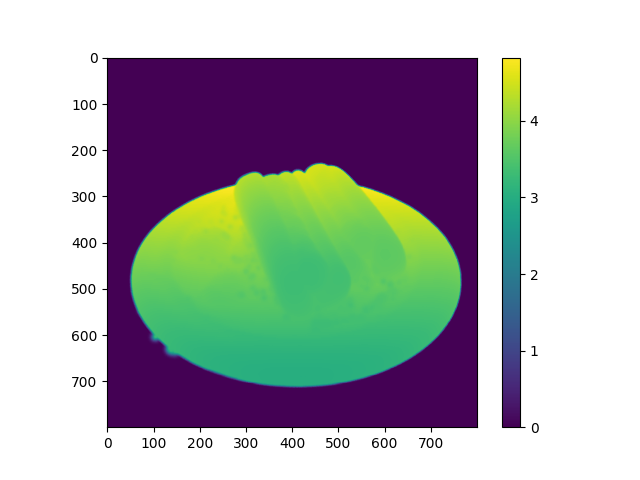

In [36]:

depth_np = depth_target.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

# Load patch of lego

In [21]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


In [22]:
loaded_data = np.load("/home/dimakot55/output_data/gs/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

#loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_brickwall_spheres_clusters_50/cluster_14.npz") # 51, 36, 49, 24, 40, 57, 45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']

# 0. only for the bricks scene. Remove poitns underneath. and change size to smaller scale. Multiply coordinates and sizes.
idcs = np.where(gaussians_xyz[:,2]>-0.12)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]




# 1. Remove poitns that are too far away from all othe points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = gaussians_xyz[idcs]
gaussians_features_dc = gaussians_features_dc[idcs]
gaussians_features_rest = gaussians_features_rest[idcs]
gaussians_rotation = gaussians_rotation[idcs]
gaussians_scaling = gaussians_scaling[idcs]
gaussians_opacity = gaussians_opacity[idcs]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
#colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
colors=sigmoid(colors)

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)


# Extra increase the volume of the points to make results more apparent
with torch.no_grad():
    # gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for lego
    gaussians_xyz[:,2] = gaussians_xyz[:,2]*1.5 # for bricks 

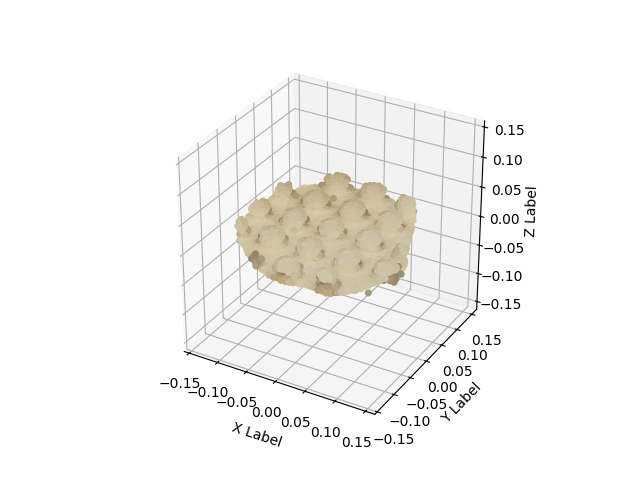

In [23]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2],#*1.5, 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()





In [24]:
gaussians_patch = GaussianModel(3)#.to(device="cuda")
scene_patch = Scene(dataset, gaussians_patch, shuffle=True)


# with torch.no_grad():
    
#     gaussians_patch._xyz = torch.nn.Parameter(torch.tensor(gaussians_xyz)).to(device=device)
#     gaussians_patch._features_dc = torch.nn.Parameter(torch.tensor(gaussians_features_dc)).to(device=device)
#     gaussians_patch._features_rest = torch.nn.Parameter(torch.tensor(gaussians_features_rest)).to(device=device)
#     gaussians_patch._rotation = torch.nn.Parameter(torch.tensor(gaussians_rotation)).to(device=device)
#     gaussians_patch._scaling = torch.nn.Parameter(torch.tensor(gaussians_scaling)).to(device=device)
#     gaussians_patch._opacity = torch.nn.Parameter(torch.tensor(gaussians_opacity)).to(device=device)
    
#     N = len(gaussians_patch._xyz)
    
#     gaussians_patch.max_radii2D = torch.nn.Parameter(torch.tensor(gaussians.max_radii2D[:N].clone().detach().cpu().numpy())).to(device=device)
#     gaussians_patch.xyz_gradient_accum = torch.nn.Parameter(torch.tensor(gaussians.xyz_gradient_accum[:N].clone().detach().cpu().numpy())).to(device=device)
#     gaussians_patch.denom = torch.nn.Parameter(torch.tensor(gaussians.denom[:N].clone().detach().cpu().numpy())).to(device=device)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [25]:
gaussians_patch._xyz.shape

torch.Size([100000, 3])

In [26]:
gaussians_patch._xyz.shape

torch.Size([100000, 3])

In [334]:
gaussians_patch._xyz.data = torch.tensor(gaussians_xyz).to(device=device)
gaussians_patch._features_dc.data = torch.tensor(gaussians_features_dc).to(device=device)
gaussians_patch._features_rest.data = torch.tensor(gaussians_features_rest).to(device=device)
gaussians_patch._rotation.data = torch.tensor(gaussians_rotation).to(device=device)
gaussians_patch._scaling.data = torch.tensor(gaussians_scaling).to(device=device)
gaussians_patch._opacity.data = torch.tensor(gaussians_opacity).to(device=device)

N = len(gaussians_patch._xyz)

gaussians_patch.max_radii2D.data = torch.tensor(gaussians.max_radii2D[:N].clone().detach().cpu().numpy()).to(device=device)
gaussians_patch.xyz_gradient_accum.data = torch.tensor(gaussians.xyz_gradient_accum[:N].clone().detach().cpu().numpy()).to(device=device)
gaussians_patch.denom.data = torch.tensor(gaussians.denom[:N].clone().detach().cpu().numpy()).to(device=device)

In [335]:
gaussians_patch._scaling.data += 2.
gaussians_patch._opacity.data += 10.

In [336]:
# viewpoint_stack = scene_patch.getTrainCameras().copy()
# viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))



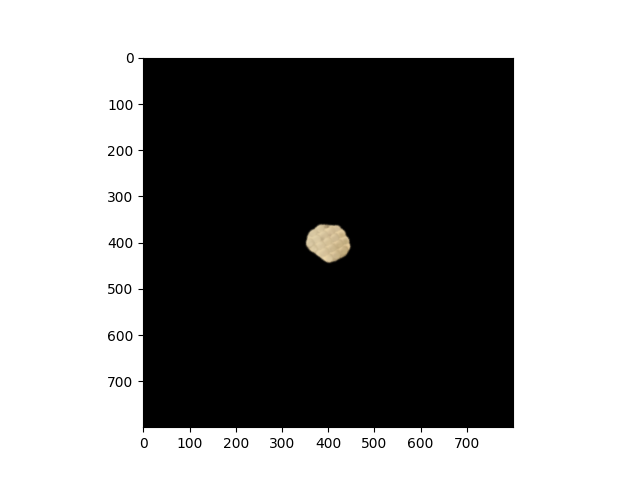

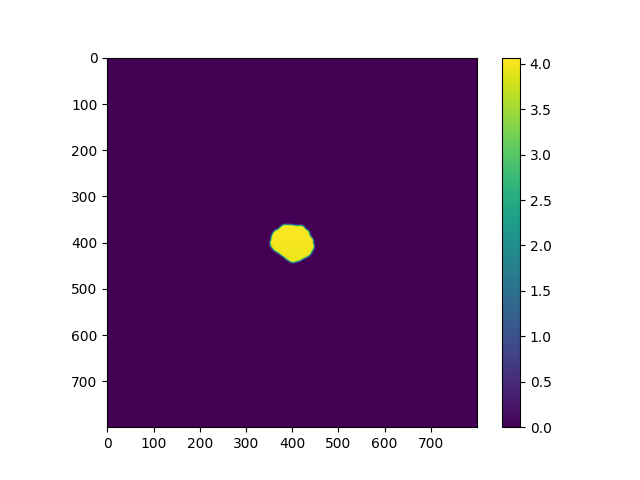

In [337]:
render_pkg = render(viewpoint_cam, gaussians_patch, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [296]:
losses=[]

gaussians_patch.training_setup(opt)
for param_group in gaussians_patch.optimizer.param_groups:
        param_group['lr'] = 1e-4

gaussians_patch._xyz.requires_grad_ = True
gaussians_patch._features_dc.requires_grad_ = False
gaussians_patch._features_rest.requires_grad_ = False
gaussians_patch._scaling.requires_grad_ = False
gaussians_patch._rotation.requires_grad_ = False
gaussians_patch._opacity.requires_grad_ = False
gaussians_patch.max_radii2D.requires_grad_ = False


In [61]:

for step in tqdm(range(5001)):
    render_pkg = render(viewpoint_cam, gaussians_patch, pipe, background)
    # Pick a random Camera
    # if not viewpoint_stack:
    #     viewpoint_stack = scene_test.getTrainCameras().copy()
    # viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

    image, depth= render_pkg["render"], render_pkg["depth"]
    #depth_target = torch.ones_like(depth)*2.
    loss = loss_to_depth_target(d=depth, d_trg=depth_target)
    #loss = loss_to_depth_target(d=depth[350:450, 350:450], d_trg=depth_target[350:450, 350:450])
    loss.backward()

    gaussians_patch.optimizer.step()
    losses.append(float(loss.detach().cpu().numpy()))#loss.cpu().numpy)
    
    if step % 100 == 0:
        print(loss)
   



/tmp/ipykernel_3694198/2467526644.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

tensor(0.0049, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0127, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0243, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0444, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0960, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1690, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1701, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2795, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3261, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1399, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0783, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0764, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0824, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0870, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0916, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0946, device='cuda:0',

KeyboardInterrupt: 

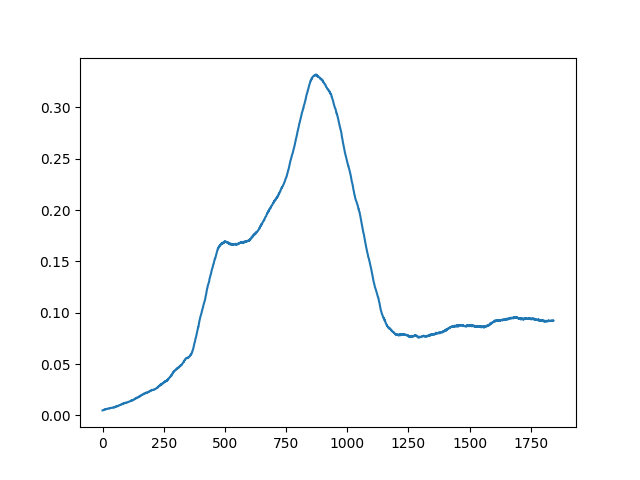

In [62]:
# plt.plot([x.cpu() for x in losses])
plt.figure()
plt.plot(losses)#np.stack([x.cpu().detach().numpy() for x in losses]))
plt.show()


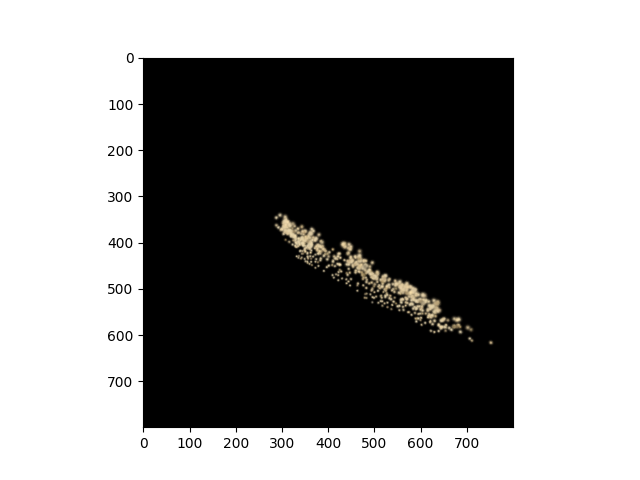

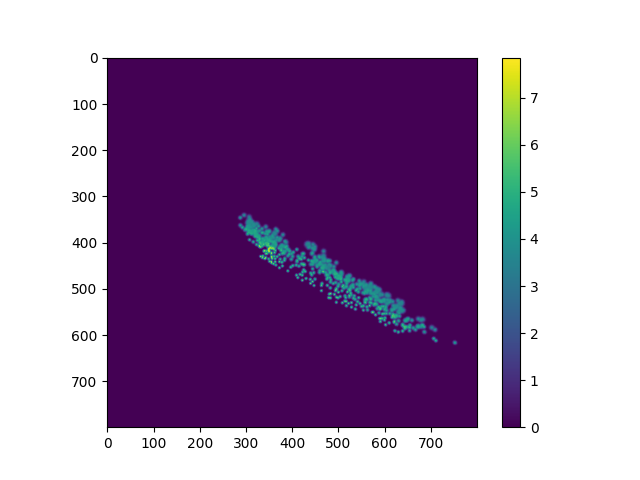

In [63]:

image, depth= render_pkg["render"], render_pkg["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

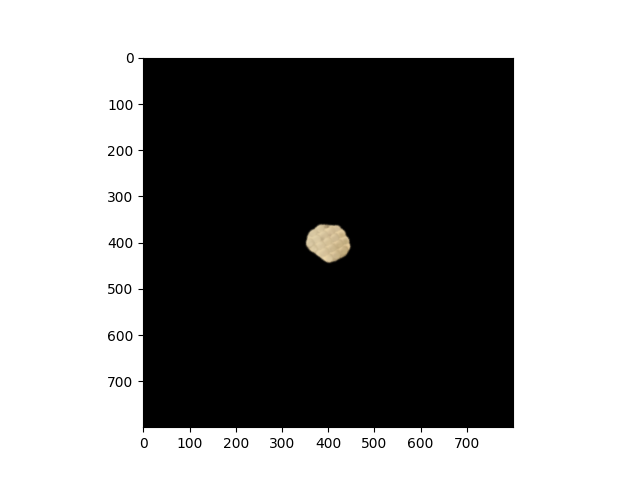

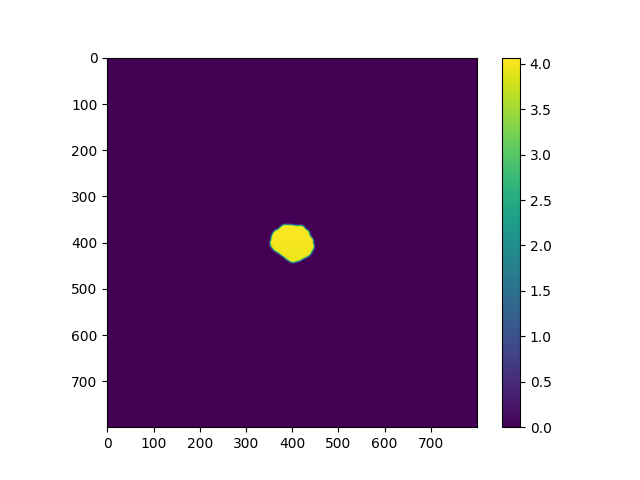

In [338]:

image, depth= render_pkg["render"], render_pkg["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

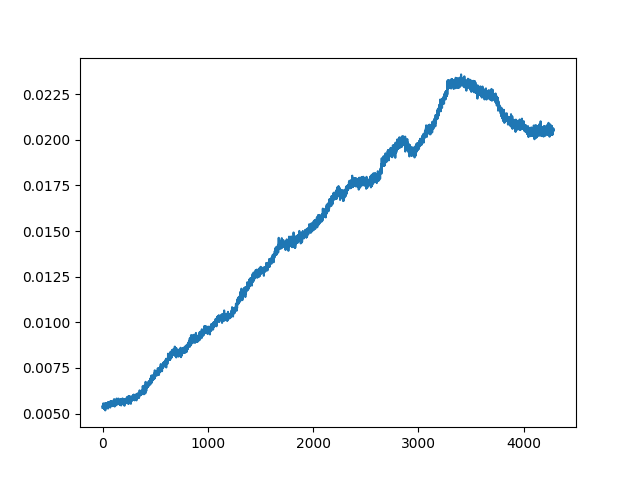

In [41]:
# plt.plot([x.cpu() for x in losses])
plt.figure()
plt.plot(losses)#np.stack([x.cpu().detach().numpy() for x in losses]))
plt.show()


In [ ]:
print("yo")

In [339]:
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns


In [340]:
num_nns = 2000
kth_nn = 20
num_nns_local = 100 # was 100
kth_nn_local = 1

distances = torch.cdist(gaussians_patch._xyz, gaussians_patch._xyz)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)

target_descriptor_points = get_descriptors(X=gaussians_patch._xyz, X_nns_indices=nns_indices[::kth_nn])
target_descriptor_points = target_descriptor_points.clone().detach()


In [341]:
losses=[]

gaussians_patch.training_setup(opt)
for param_group in gaussians_patch.optimizer.param_groups:
        param_group['lr'] = 1e-3

gaussians_patch._xyz.requires_grad_ = True
gaussians_patch._features_dc.requires_grad_ = False
gaussians_patch._features_rest.requires_grad_ = False
gaussians_patch._scaling.requires_grad_ = False
gaussians_patch._rotation.requires_grad_ = False
gaussians_patch._opacity.requires_grad_ = False
gaussians_patch.max_radii2D.requires_grad_ = False


In [342]:
import torch.nn.functional as F
N = 10
# Define a 2D Gaussian blur kernel
blur_kernel_size = 2*N
blur_sigma = float(N)
blur_kernel = torch.exp(
    -torch.arange(blur_kernel_size).float()**2 / (2.0 * blur_sigma**2)
)
blur_kernel = blur_kernel / blur_kernel.sum()

# Apply the 2D Gaussian blur kernel using the F.conv2d function
depth_target_blurred = F.conv2d(depth_target.unsqueeze(0).unsqueeze(0), 
                                blur_kernel.view(1, 1, 2*N, 1).to(device=device), 
                                padding=blur_kernel_size // 2)


depth_target_blurred =  F.conv2d(depth_target_blurred, 
                                blur_kernel.view(1, 1, 1, 2*N).to(device=device), 
                                padding=blur_kernel_size // 2)

depth_target_blurred = depth_target_blurred.squeeze(0).squeeze(0)[N+1 :-N,N+1:-N]

In [343]:
depth_target_blurred.shape

torch.Size([800, 800])

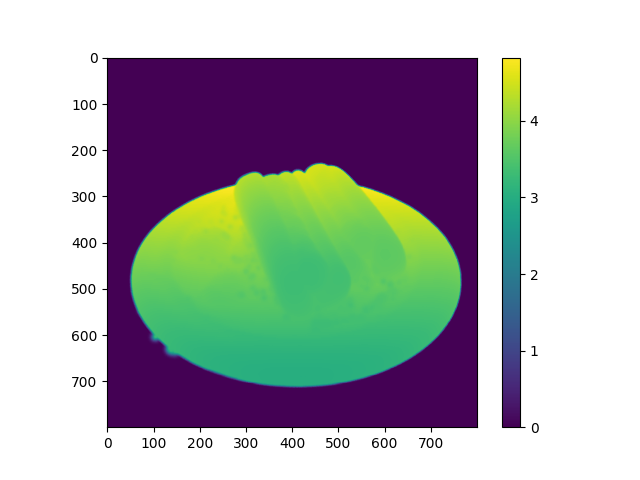

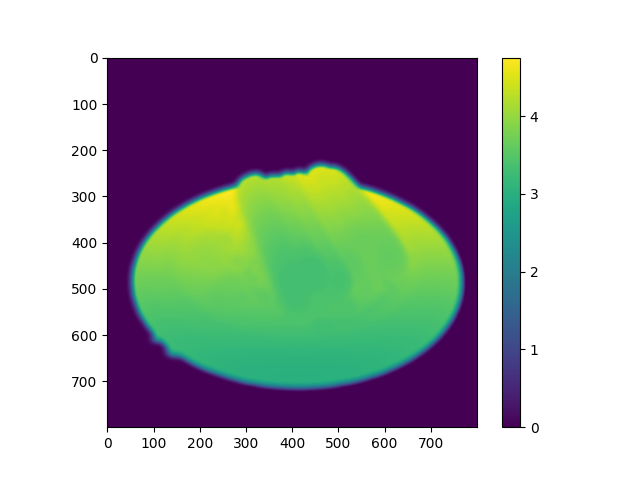

In [344]:

depth_np = depth_target.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


depth_np = depth_target_blurred.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()



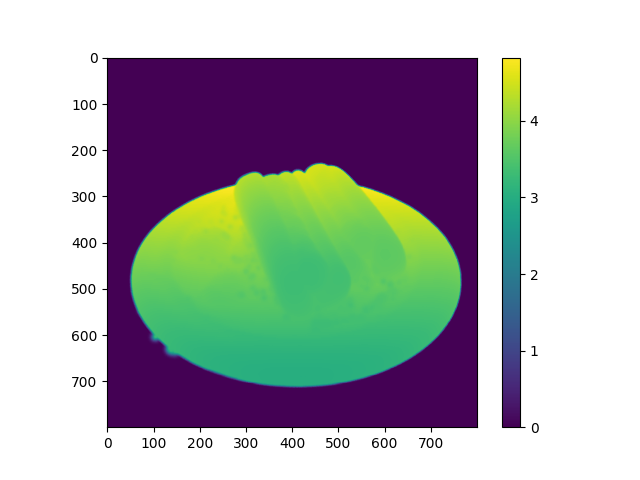

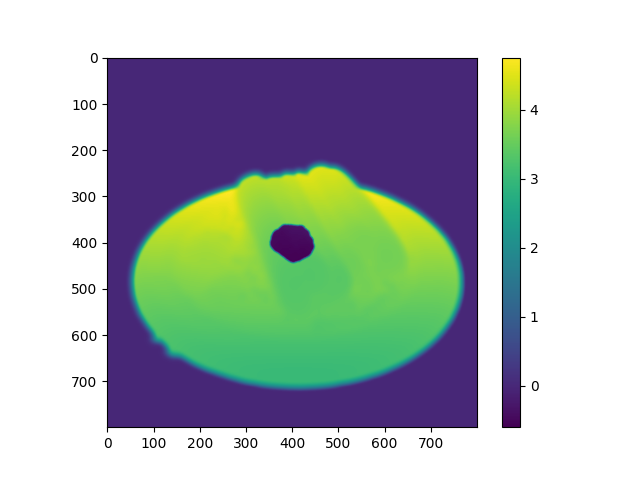

In [345]:


depth_np = depth_target.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()




depth_np = depth_target_blurred.detach().cpu().numpy() - depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [353]:
target_descriptor_points

tensor([[0.0054, 0.0055, 0.0056,  ..., 0.2080, 0.2081, 0.2082],
        [0.0050, 0.0051, 0.0052,  ..., 0.1271, 0.1272, 0.1272],
        [0.0050, 0.0054, 0.0056,  ..., 0.1302, 0.1302, 0.1302],
        ...,
        [0.0072, 0.0073, 0.0077,  ..., 0.1509, 0.1511, 0.1511],
        [0.0050, 0.0051, 0.0051,  ..., 0.1237, 0.1237, 0.1238],
        [0.0053, 0.0058, 0.0061,  ..., 0.1817, 0.1817, 0.1818]],
       device='cuda:0')

In [354]:
descriptor_points

tensor([[0.4254, 0.1194, 0.0831,  ..., 0.3523, 0.4666, 0.7231],
        [0.8680, 0.9432, 0.7328,  ..., 1.4252, 0.9073, 1.0205],
        [0.0137, 0.0283, 0.0023,  ..., 0.4606, 0.9357, 1.5503],
        ...,
        [0.4092, 0.4970, 0.6746,  ..., 0.7275, 0.6302, 0.7354],
        [0.9754, 1.0420, 1.0440,  ..., 0.1859, 0.1066, 0.1389],
        [1.4811, 0.6813, 1.4868,  ..., 0.1086, 0.2694, 1.5409]],
       device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [370]:



for step in tqdm(range(15001)):
    gaussians_patch.optimizer.zero_grad()
    render_pkg = render(viewpoint_cam, gaussians_patch, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    #print(nns_indices)

    descriptor_points = get_descriptors(X=gaussians_patch._xyz, X_nns_indices=nns_indices[::kth_nn])
    loss_local_descriptors = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)

    loss_depth = loss_to_depth_target(d=depth, d_trg=depth_target_blurred)
    # d_trg=torch.ones_like(depth)*6.)# depth_target)

    loss = loss_depth * .1 + 1. * loss_local_descriptors
    #loss = loss_to_depth_target(d=depth[350:450, 350:450], d_trg=depth_target[350:450, 350:450])
    loss.backward()

    gaussians_patch.optimizer.step()
    losses.append(float(loss.detach().cpu().numpy()))#loss.cpu().numpy)
    
    if step % 500 == 0:

        print(f"loss_depth:{loss_depth:.7f}, loss_local_descriptors:{loss_local_descriptors:.7f}, loss:{loss:.7f}")


/tmp/ipykernel_3694198/3671360592.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(15001)):


  0%|          | 0/15001 [00:00<?, ?it/s]

loss_depth:0.0034443, loss_local_descriptors:0.0000164, loss:0.0003608
loss_depth:0.0042749, loss_local_descriptors:0.0000017, loss:0.0004292
loss_depth:0.0040213, loss_local_descriptors:0.0000018, loss:0.0004039


KeyboardInterrupt: 

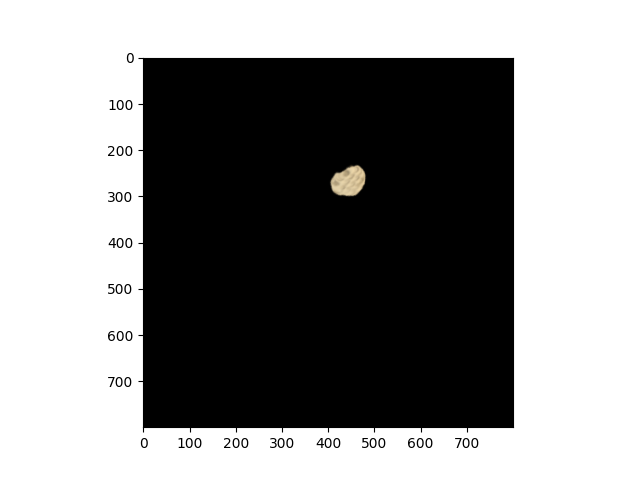

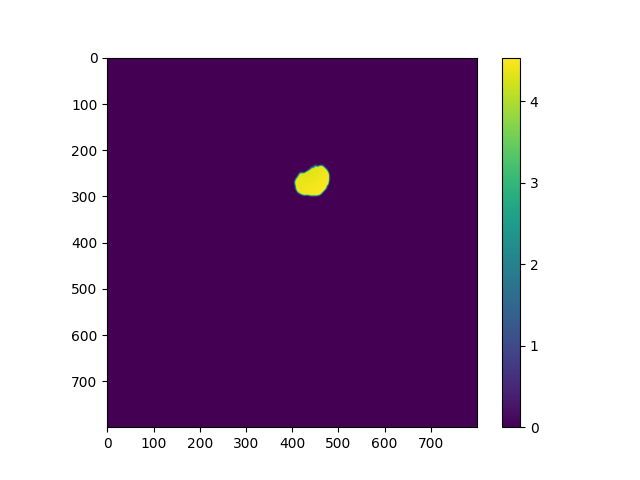

In [373]:

image, depth= render_pkg["render"], render_pkg["depth"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
image_rgb = np.clip(image_rgb*255, 0, 255).astype(np.uint8) 

plt.figure()
plt.imshow(image_rgb)
plt.show()

depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

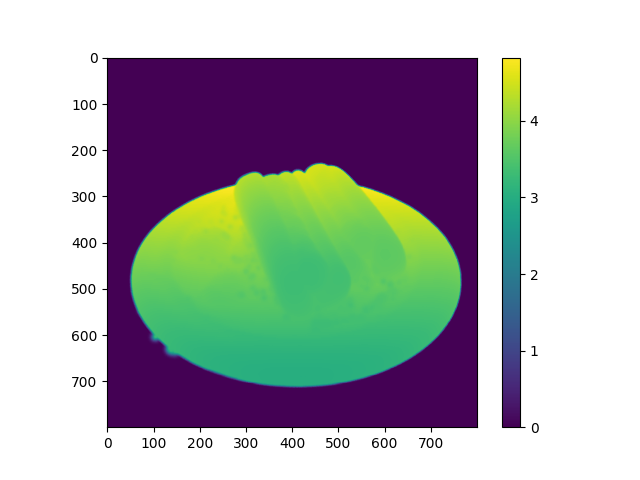

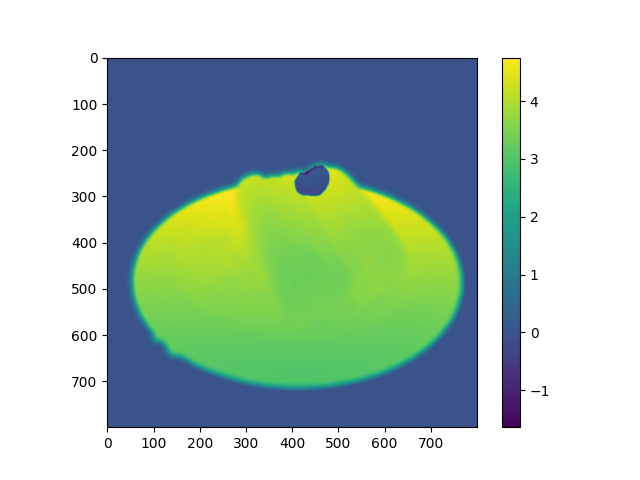

In [372]:


depth_np = depth_target.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()




depth_np = depth_target_blurred.detach().cpu().numpy() - depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()